In [23]:
import pickle
import random
import numpy as np
import pandas as pd
from scipy.stats import ks_2samp
from tqdm.auto import tqdm

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({"font.size" : 15,
                     "figure.dpi" : 100, 
                     "grid.alpha" : 0.3, 
                     "axes.grid": False, 
                     "axes.axisbelow" : True,
                     "figure.figsize":(8,6),
                     "mathtext.fontset":"cm",
                     "xtick.labelsize": 14,
                     "ytick.labelsize": 14,
                     "axes.labelsize": 16, 
                     "legend.fontsize": 13.5})
plt.rc("text", usetex=False)
plt.rc("font", family="serif")

In [3]:
with open("./agent_final_wealths.pickle", "rb") as f:
    W = pickle.load(f)
with open("./regime.pickle", "rb") as f:
    r = pickle.load(f)

In [36]:
AP = np.where(r==0)
SR = np.where(r==1)
AR = np.where(r==2)

In [45]:
def norm(values):
    values = np.array(values)
    min_val = values.min()
    max_val = values.max()
    return (values - min_val) / (max_val - min_val)

In [46]:
def compute_ks_distance_ccdf(x1, y1, x2, y2):
    """
    Compute the KS distance between two empirical CCDFs.
    
    Parameters:
        x1, y1: arrays for first CCDF (x values and corresponding CCDF values)
        x2, y2: arrays for second CCDF (x values and corresponding CCDF values)
        
    Returns:
        ks_distance: float
    """
    # Combine all x values
    x_all = np.union1d(x1, x2)

    # Interpolate CCDFs to the same x values
    y1_interp = np.interp(x_all, x1, y1, left=1.0, right=0.0)
    y2_interp = np.interp(x_all, x2, y2, left=1.0, right=0.0)

    # Compute max absolute difference
    ks_distance = np.max(np.abs(y1_interp - y2_interp))
    
    return ks_distance

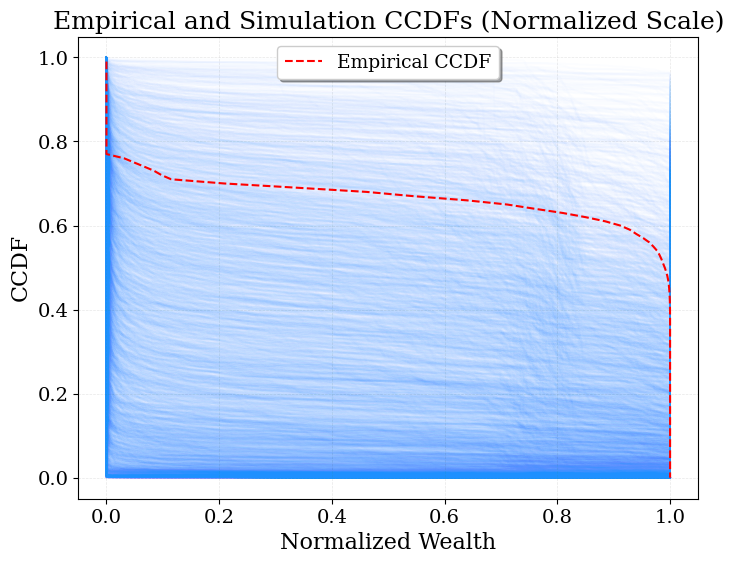

In [15]:
plt.figure(figsize=(8, 6))

num_samples = 5000
rand_idx = random.sample(list(range(len(W[SR]))), k=num_samples)
for i,row in enumerate(W[SR][rand_idx]):
    row[row < 1] = 1
    row = norm(row)
    data_sorted = np.sort(row)
    cdf = np.arange(1, len(data_sorted)+1, dtype=np.float64) / len(data_sorted)
    plt.plot(data_sorted, 1-cdf, alpha=0.01, c="dodgerblue")


# Step 1: Load the Excel file
file_path = "wealth.xlsx"
data = pd.read_excel(file_path)

# Step 2: Extract relevant columns
percentiles = data.iloc[:, 0]
wealth_values = data.iloc[:, 1]

# Step 3: Compute the empirical complement of the CDF
ccdf = 1 - percentiles / 100

# Step 4: Normalize wealth values using 1 - exp(-kx)
k = 0.00008
normalized_wealth = 1 - np.exp(-k * wealth_values)
normalized_wealth = np.maximum(normalized_wealth, 0)

# Plot empirical CCDF (normalized scale)
plt.plot(normalized_wealth, ccdf, label="Empirical CCDF", color="red", linestyle="dashed")

# Plot parametric CCDF (normalized scale)
#plt.plot(wealth_parametric, complement_cdf_parametric, label=f"Parametric CCDF (Pareto, α={alpha:.2f})", color="red", linestyle="--")

# Configure plot
plt.xlabel("Normalized Wealth")
plt.ylabel("CCDF")
plt.title("Empirical and Simulation CCDFs (Normalized Scale)")
plt.legend(shadow=True, loc="upper center")
plt.grid(which="both", linestyle="--", linewidth=0.5)
plt.show()

In [41]:
d = []
for row in tqdm(W[SR]):
    row[row < 1] = 1
    row = norm(row)
    data_sorted = np.sort(row)
    row_ccdf = 1 - np.arange(1, len(data_sorted)+1, dtype=np.float64) / len(data_sorted)
    d.append(
        compute_ks_distance_ccdf(
            data_sorted, row_ccdf, normalized_wealth, ccdf
        )
    )

  0%|          | 0/125736 [00:00<?, ?it/s]

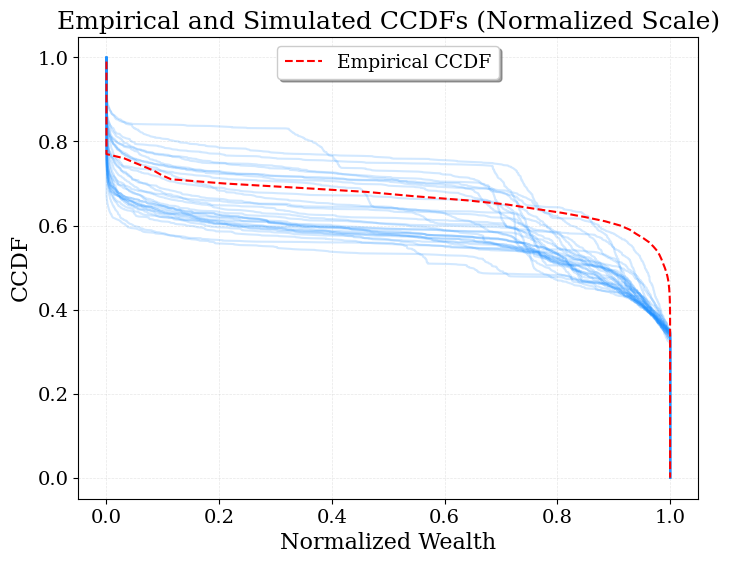

In [54]:
plt.figure(figsize=(8, 6))

rand_idx = np.argsort(d)[:30]
for i,row in enumerate(W[SR][rand_idx]):
    row[row < 1] = 1
    row = norm(row)
    data_sorted = np.sort(row)
    cdf = np.arange(1, len(data_sorted)+1, dtype=np.float64) / len(data_sorted)
    plt.plot(data_sorted, 1-cdf, alpha=0.2, c="dodgerblue")


# Step 1: Load the Excel file
file_path = "wealth.xlsx"
data = pd.read_excel(file_path)

# Step 2: Extract relevant columns
percentiles = data.iloc[:, 0]
wealth_values = data.iloc[:, 1]

# Step 3: Compute the empirical complement of the CDF
ccdf = 1 - percentiles / 100

# Step 4: Normalize wealth values using 1 - exp(-kx)
k = 0.00008
normalized_wealth = 1 - np.exp(-k * wealth_values)
normalized_wealth = np.maximum(normalized_wealth, 0)

# Plot empirical CCDF (normalized scale)
plt.plot(normalized_wealth, ccdf, label="Empirical CCDF", color="red", linestyle="dashed")

# Plot parametric CCDF (normalized scale)
#plt.plot(wealth_parametric, complement_cdf_parametric, label=f"Parametric CCDF (Pareto, α={alpha:.2f})", color="red", linestyle="--")

# Configure plot
plt.xlabel("Normalized Wealth")
plt.ylabel("CCDF")
plt.title("Empirical and Simulated CCDFs (Normalized Scale)")
plt.legend(shadow=True, loc="upper center")
plt.grid(which="both", linestyle="--", linewidth=0.5)
plt.savefig("ccdf.pdf", bbox_inches="tight")
plt.show()

In [57]:
import sys

from SALib.sample import saltelli
from tqdm import tqdm
import numpy as np
import pandas as pd
import pickle
import lzma
import os

In [58]:
# problem definition
PROBLEM = {
    "num_vars" : 5,
    "names"    : ["theta",
                  "gain_right",
                  "saving_prop",
                  "prob_left",
                  "alpha"],
    "bounds"   : [[0.05, 0.95],
                  [1.70, 8.00],
                  [0.70, 0.80],
                  [0.30, 0.45],
                  [2.00, 12.0]]
}

# generate Saltelli samples
NUM_SAMPLES = 1024
X = saltelli.sample(PROBLEM, NUM_SAMPLES, calc_second_order=False)

/var/folders/mz/n_rzzjx149d19ncnxglpf7n40000gn/T/ipykernel_3148/3978182710.py:18: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5.1 Please use `salib.sample.sobol`
  X = saltelli.sample(PROBLEM, NUM_SAMPLES, calc_second_order=False)


In [64]:
rand_idx

array([ 90660,  90657,  42376,  19602, 117826, 102934,  25194,  23020,
          707,  83482,  72384,  66121,   6219,  99305,  25190, 120487,
        16025,  75975,  96950,  44923,  47827,  77221, 122827,  88749,
        63480,  63481,  40690,   5372,  62068,  46924])

In [59]:
X.shape

(7168, 5)

In [62]:
r.shape

(20, 7168)

In [74]:
SR[1][90660], SR[1][90657], SR[1][42376], SR[1][19602] 

(np.int64(2958), np.int64(2955), np.int64(5073), np.int64(591))

In [75]:
X[2958], X[2955], X[5073], X[591]

(array([0.66479492, 2.85356445, 0.77504883, 0.33566895, 3.64550781]),
 array([0.39672852, 2.85356445, 0.77504883, 0.32468262, 3.64550781]),
 array([0.49165039, 1.9737793 , 0.77807617, 0.32717285, 2.25878906]),
 array([0.49428711, 2.44750977, 0.75952148, 0.43278809, 2.02441406]))